In [223]:
from chirho_diffeqpy import DiffEqPy, ATempParams, PureDynamics
from chirho.dynamical.handlers.solver import TorchDiffEq
from chirho.dynamical.ops import simulate
from chirho.dynamical.handlers.trajectory import LogTrajectory
from chirho.dynamical.handlers import StaticBatchObservation, StaticIntervention, DynamicIntervention
from chirho.counterfactual.handlers import MultiWorldCounterfactual
from chirho.observational.handlers import condition
from chirho.dynamical.ops import State
import numpy as np
import torch
from pyro import sample, set_rng_seed
from pyro.distributions import Uniform, Poisson
from typing import Tuple, Optional, Union, Callable
from functools import partial
from numbers import Real
import matplotlib.pyplot as plt
from typing import List
import pyro
import pyro.distributions as dist
from pyro.infer.autoguide import AutoDelta, AutoMultivariateNormal
from contextlib import nullcontext
# The DiffEqPy backend interfaces with julia, so we must load a julia<>python interop backend.
import chirho_diffeqpy.lang_interop.julianumpy
from contextlib import ExitStack, nullcontext
from pyro.contrib.autoname import scope
# Global params are weird.
from functools import singledispatch, partial
import pyro
import torch
import zuko
from pyro.contrib.zuko import ZukoToPyro
from pyro.contrib.easyguide import easy_guide
from collections import namedtuple
from chirho.observational.handlers import condition

pyro.settings.set(module_local_params=True)
torch.set_default_dtype(torch.float64)
# pyro.set_rng_seed(82901)

In [224]:
def sinusoid_dynamics(state: State, atemp_params: ATempParams):
    frequency = atemp_params['frequency']
    amplitude = atemp_params['amplitude']
    t = state['t']
    
    return dict(
        # The time derivative of a sin wave, plus a decay term.
        y=amplitude * frequency * np.cos(frequency * t) - state['y']
    )

SOLVER = DiffEqPy()

In [225]:
def stochastic_jump_model(num_jumps: int, start_time: torch.Tensor, end_time: torch.Tensor, noise_per_time_unit: float):
   
    # <Dynamics>
    initial_state = dict(
        # y=sample("y0", dist.Normal(0.0, 1.0)),
        y=torch.tensor(3.0)
    )
    
    sinusoid_params = dict(
        # frequency=sample("frequency", dist.Uniform(0.1, torch.pi)),
        frequency=torch.tensor(1.0),
        # amplitude=sample("amplitude", dist.Uniform(0.1, 2.0)),
        amplitude=torch.tensor(1.0)
    )
    # </Dynamics>
    
    # <Jump Model>
    jump_times = sample("jump_times", Uniform(start_time, end_time).expand([num_jumps]))
    
    # Compute the noise prior. I'm not really sure how this should be handled, but the idea
    #  is to make it kinda brownian, where noise is proportional to the average distance between
    #  jumps.
    total_time = end_time - start_time
    total_noise = noise_per_time_unit * total_time
    noise_per_jump = total_noise / num_jumps
    # In this case I'm just saying that the noise can't be larger than the brownian assumption would allow.
    # Maybe `max_noise_per_time_unit` and `max_noise_per_jump` would be appropriate.
    # I think bounding it this way would require the jump times to space themselves out more or less evenly?
    noises = sample("noises", dist.Uniform(0.001, noise_per_jump).expand([num_jumps]))
    
    def jump_intervention_fn(val: torch.Tensor, jump_idx: int, noise: torch.Tensor):
        return val + sample(f"jump{jump_idx}", dist.Normal(0.0, noise))
    
    jump_interventions = ExitStack()
    for i, (jump_time, noise) in enumerate(zip(jump_times, noises)):
        jump_intervention = StaticIntervention(
            time=jump_time,
            intervention=dict(y=partial(jump_intervention_fn, jump_idx=i, noise=noise))
        )
        jump_interventions.enter_context(jump_intervention)
    
    with jump_interventions:
        simulate(
            sinusoid_dynamics,
            initial_state,
            start_time,
            end_time,
            atemp_params=sinusoid_params,
        )
    # </Jump Model>
    
    return jump_times

In [226]:
START_T = 0.0
END_T = 10.0
NOISE_PER_TIME_UNIT = 5.0
NUM_JUMPS = 1000
RES = 10000

with SOLVER, LogTrajectory(times=torch.linspace(START_T, END_T, RES)) as lt:
    jump_times = stochastic_jump_model(NUM_JUMPS, torch.tensor(START_T), torch.tensor(END_T), NOISE_PER_TIME_UNIT)

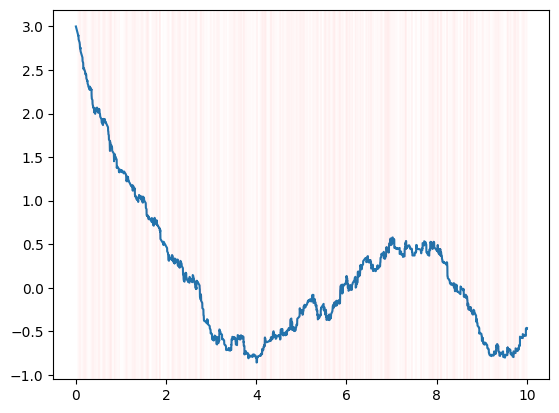

In [227]:
plt.figure()
plt.plot(lt.times, lt.trajectory['y'])
for jump_time in jump_times:
    plt.axvline(jump_time.item(), color='red', linestyle='--', linewidth=0.01)